## Proyecto 1 

Nicolas Arango - 202220342
Mateo Rincon - 202221402
Amalia Carbonell - 202122079 



1. Entendimiento y preparación de los datos (a nivel de código y análisis).
2. Modelado y evaluación.

### Entendimiento y preparación de los datos (a nivel de código y análisis)

In [83]:
import os
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

import scipy.stats as stats

In [84]:
import nltk
import nltk.tokenize

nltk.data.path.append('./nltk_data')
from nltk.tokenize import sent_tokenize
# nltk.download('punkt', download_dir='/Users/nicolasarango/Library/Mobile Documents/com~apple~CloudDocs/Sexto Semestre/BI/Proyectos/Proyecto1/nltk_data')
# nltk.download('punkt_tab', download_dir='/Users/nicolasarango/Library/Mobile Documents/com~apple~CloudDocs/Sexto Semestre/BI/Proyectos/Proyecto1/nltk_data')
# nltk.download('stopwords', download_dir='/Users/nicolasarango/Library/Mobile Documents/com~apple~CloudDocs/Sexto Semestre/BI/Proyectos/Proyecto1/nltk_data')
# nltk.download('wordnet', download_dir='/Users/nicolasarango/Library/Mobile Documents/com~apple~CloudDocs/Sexto Semestre/BI/Proyectos/Proyecto1/nltk_data')


In [85]:
stopwords_spanish = stopwords.words('spanish')
lemmatizer = WordNetLemmatizer()

In [86]:
# Carga de Datos
#noticias_df = pd.read_csv("./data/fake_news_test.csv", sep=";", usecols=['ID','Titulo', "Descripcion", "Fecha"])
datax=pd.read_csv('./data/fake_news_spanish.csv', sep=';', encoding = 'utf-8')

In [87]:
# Es recomendable que todos los pasos de limpieza y preparación se realicen sobre otro archivo.
data = datax.copy()
# Eliminación de registros duplicados.
data=data.drop_duplicates()

data.shape


(56618, 5)

In [88]:
data.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

In [89]:
# Contar los tipos de datos en la columna "Titulo"
tipo_datos = data['Titulo'].apply(type).value_counts()
print(tipo_datos)

print(data['Titulo'][data['Titulo'].apply(type) == float])


Titulo
<class 'str'>      56602
<class 'float'>       16
Name: count, dtype: int64
3243     NaN
4189     NaN
5041     NaN
5644     NaN
7345     NaN
7652     NaN
9700     NaN
15159    NaN
19415    NaN
24806    NaN
35816    NaN
36724    NaN
40295    NaN
41810    NaN
47967    NaN
55146    NaN
Name: Titulo, dtype: object


In [90]:
# cambiar float a String
data['Titulo'] = data['Titulo'].apply(lambda x: str(x) if isinstance(x, float) else x)
# cambiar float a String vacio ("")
data['Titulo'] = data['Titulo'].apply(lambda x: "" if x == "nan" else x)
tipo_datos = data['Titulo'].apply(type).value_counts()
print(tipo_datos)


Titulo
<class 'str'>    56618
Name: count, dtype: int64


In [91]:
# Contar los tipos de datos en la columna "Descripcion"
tipo_datos = data['Descripcion'].apply(type).value_counts()
print(tipo_datos)

Descripcion
<class 'str'>    56618
Name: count, dtype: int64


In [92]:
data.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


### Describir los Datos

Se hace una descripción más detallada de nuestros datos.Es un paso es muy importante para poder determinar problemas de calidad de datos. Además, nos dará información que será útil en la fase de preparación de datos.

In [93]:
data.describe()

,Label
count,56618.000000
mean,0.578226
std,0.493847
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56618 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           56618 non-null  object
 1   Label        56618 non-null  int64 
 2   Titulo       56618 non-null  object
 3   Descripcion  56618 non-null  object
 4   Fecha        56618 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.6+ MB


In [95]:
# Se calcula el porcentaje de los valores nulos por columna
print((data.isnull().sum()*100 / data.shape[0]).sort_values(ascending=False))

ID             0.0
Label          0.0
Titulo         0.0
Descripcion    0.0
Fecha          0.0
dtype: float64


In [96]:
# Analizar la duplicidad de los datos
data.duplicated().sum()

np.int64(0)

<Axes: xlabel='Label'>

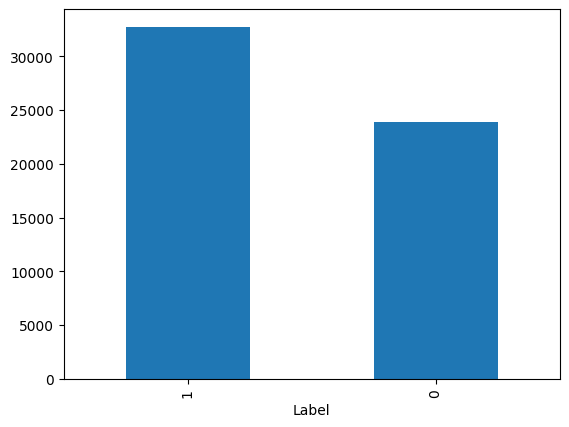

In [97]:
# Analizar distribución de noticias falsas
data['Label'].value_counts().plot(kind='bar')

## Lenguaje natural

In [98]:
from nltk.stem import PorterStemmer
import re
stemmer = SnowballStemmer('spanish')

In [99]:
def preprocessor(text):
    text = re.sub(r'<[^>]*>', '', text)  # Eliminar etiquetas HTML
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuaciones
    text = text.lower().strip()  # Convertir a minúsculas y eliminar espacios extra
    return text

In [100]:
data['Titulo'] = data['Titulo'].apply(preprocessor)
data['Descripcion'] = data['Descripcion'].apply(preprocessor)

In [101]:
# wpt = nltk.WordPunctTokenizer()
# ps = PorterStemmer()
# nltk.download('stopwords')
# stop_words = nltk.corpus.stopwords.words('spanish')

# def normalize_documents(doc):
#   doc = re.sub(r'[^a-zA-Z\s]','',doc, re.I|re.A)
#   doc = doc.lower()
#   doc = doc.strip()
#   tokens = wpt.tokenize(doc)
#   filtered_token = [ps.stem(token) for token in tokens if token not in stop_words]
#   doc = ' '.join(filtered_token)
#   return doc

In [102]:
# normalize_corpus = np.vectorize(normalize_documents)
# data['Titulo'] = data['Titulo'].apply(normalize_corpus)
# data['Descripcion'] = data['Descripcion'].apply(normalize_corpus)
data.head(20)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,the guardian va con sánchez europa necesita qu...,el diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,revelan que el gobierno negocio la liberación ...,revelan que el gobierno negocio la liberación ...,01/10/2023
2,ID,1,el ahora o nunca de joan fuster sobre el estat...,el valencianismo convoca en castelló su fiesta...,25/04/2022
3,ID,1,iglesias alienta a yolanda díaz erc y eh bildu...,en política igual que hay que negociar con los...,03/01/2022
4,ID,0,puigdemont no sería ninguna tragedia una repet...,en una entrevista en el punt avui el líder de ...,09/03/2018
5,ID,1,el pnv consolida su mayoría el pse salva los p...,los nacionalistas consiguen las alcaldías de b...,26/05/2019
6,ID,0,el exconsejero núria marín pide el indulto en ...,sus familiares aluden a su honestidad e integr...,16/09/2022
7,ID,1,la fiscalía pide prisión incondicional para lo...,suprime el delito de rebelión que les imputó i...,26/09/2019
8,ID,1,josé manuel pérez tornero el creador de la tel...,el futuro presidente de rtve es licenciado en ...,25/02/2021
9,ID,0,la ayusización del bng santiago abascal instru...,pablo santiago abascal planea vivir de las ren...,10/05/2021


## N-Gramas

In [103]:
bv = CountVectorizer(ngram_range=(2,3), max_features=100000)#Usa 10,000 palabras mas comunes

bv_matrix = bv.fit_transform(data['Titulo'])
bv_matrix2 = bv.fit_transform(data['Descripcion'])
#bv_matrix = bv_matrix.toarray()
#bv_matrix2 = bv_matrix2.toarray()
vocab = bv.get_feature_names_out()
#pd.DataFrame(bv_matrix, columns=vocab)

In [104]:
# Concatenar 'Titulo' y 'Descripcion' en una sola columna de texto
data['Texto'] = data['Titulo'] + " " + data['Descripcion']

# Dividir el conjunto de datos
X_train, X_test, Y_train, Y_test = train_test_split(
    data['Texto'], data['Label'], test_size=0.3, stratify=data['Label'], random_state=1
)



#X_train, X_test, Y_train, Y_test = train_test_split(data['Titulo'], data['Label'], test_size=0.3, stratify=data['Label'], random_state=1)

In [105]:
X_train.shape, X_test.shape

((39632,), (16986,))

In [106]:
pd.Series(Y_train).value_counts(normalize=True)

Label
1    0.57822
0    0.42178
Name: proportion, dtype: float64

<Axes: xlabel='Label'>

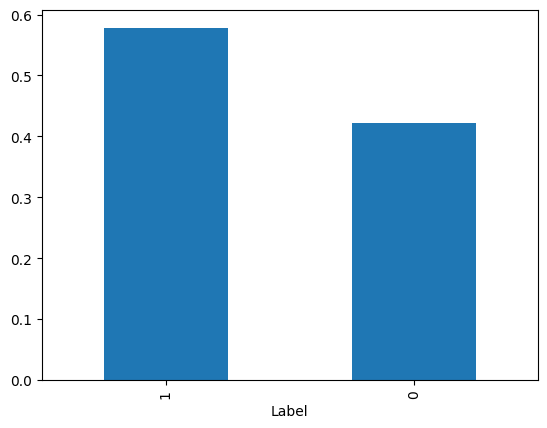

In [107]:
Y_train.value_counts(normalize=True).plot(kind='bar')

In [108]:
pd.Series(Y_test).value_counts(normalize=True)

Label
1    0.578241
0    0.421759
Name: proportion, dtype: float64

In [109]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stopwords_spanish, lowercase=True, token_pattern=None)

In [110]:
bow

CountVectorizer(stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                token_pattern=None,
                tokenizer=<function word_tokenize at 0x00000122057339C0>)

In [111]:
X_bow_train = bow.fit_transform(X_train)

In [112]:
len(bow.vocabulary_)

47178

In [113]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopwords_spanish, lowercase=True)

In [114]:
X_tfidf = tfidf.fit_transform(X_train)

C:\Users\matri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [115]:
len(tfidf.vocabulary_)

47178

In [116]:
X_tfidf.shape

(39632, 47178)

# Algoritmos de clasificación

### Support Vector Machines

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      7164
           1       0.89      0.96      0.92      9822

    accuracy                           0.91     16986
   macro avg       0.91      0.90      0.90     16986
weighted avg       0.91      0.91      0.91     16986



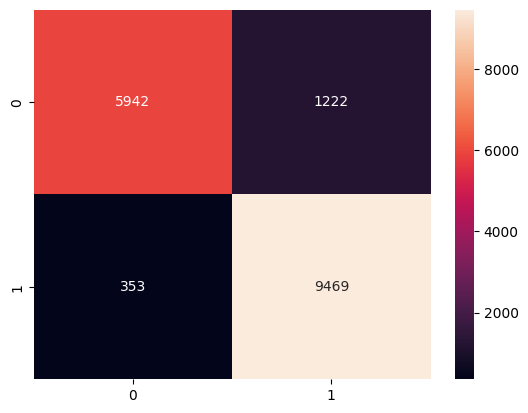

In [117]:
# crean un modelo de SVM para clasificar las noticias
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_tfidf, Y_train)

X_tfidf_test = tfidf.transform(X_test)
Y_pred = svm.predict(X_tfidf_test)
accuracy_score(Y_test, Y_pred)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d')

from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

#from sklearn.model_selection import GridSearchCV

#param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
#grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
#grid.fit(X_tfidf, Y_train)

#grid.best_params_

#grid.best_estimator_

#grid_predictions = grid.predict(X_tfidf_test)
#accuracy_score(Y_test, grid_predictions)


In [118]:
from sklearn import svm

bow_clf = svm.SVC(kernel='linear')
bow_clf.fit(X_bow_train, Y_train)

y_train_bow_pred = bow_clf.predict(X_bow_train)
y_test_bow_pred = bow_clf.predict(bow.transform(X_test))

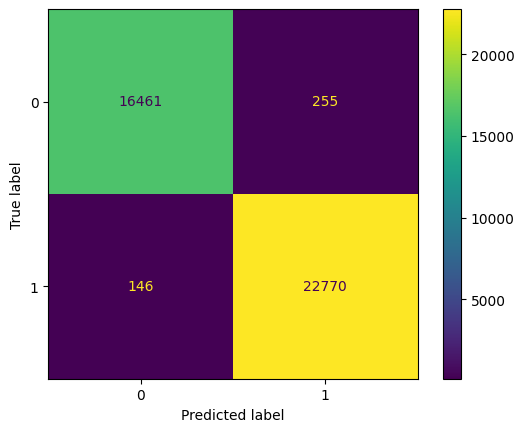

In [119]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_train, y_train_bow_pred)

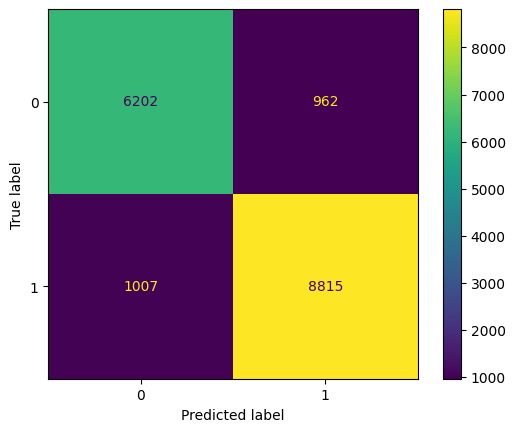

In [120]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_test_bow_pred)

In [121]:
if len(bow_clf.classes_) == 2:
    print('Precision: ', metrics.precision_score(Y_train, y_train_bow_pred, pos_label=1))
    print('Recall: ', metrics.recall_score(Y_train, y_train_bow_pred, pos_label=1))
    print('F1: ', metrics.f1_score(Y_train, y_train_bow_pred, pos_label=1))
else:
    print('Precision: ', metrics.precision_score(Y_train, y_train_bow_pred, average=None))
    print('Recall: ', metrics.recall_score(Y_train, y_train_bow_pred, average=None))
    print('F1: ', metrics.f1_score(Y_train, y_train_bow_pred, average=None))

Precision:  0.9889250814332248
Recall:  0.993628905568162
F1:  0.9912714133344942


In [122]:
if len(bow_clf.classes_) == 2:
    print('Precision: ', metrics.precision_score(Y_test, y_test_bow_pred, pos_label=1))
    print('Recall: ', metrics.recall_score(Y_test, y_test_bow_pred, pos_label=1))
    print('F1: ', metrics.f1_score(Y_test, y_test_bow_pred, pos_label=1))
else:
    print('Precision: ', metrics.precision_score(Y_test, y_test_bow_pred, average=None))
    print('Recall: ', metrics.recall_score(Y_test, y_test_bow_pred, pos_label=1))
    print('F1: ', metrics.f1_score(Y_test, y_test_bow_pred, pos_label=1))

Precision:  0.9016058095530326
Recall:  0.897475055996742
F1:  0.899535690596459


### TD-IDF

In [123]:
tfidf_clf = svm.SVC(kernel='linear')
tfidf_clf.fit(X_tfidf, Y_train)

SVC(kernel='linear')

In [124]:
y_train_tfidf_pred = tfidf_clf.predict(X_tfidf)
y_test_tfidf_pred = tfidf_clf.predict(tfidf.transform(X_test))

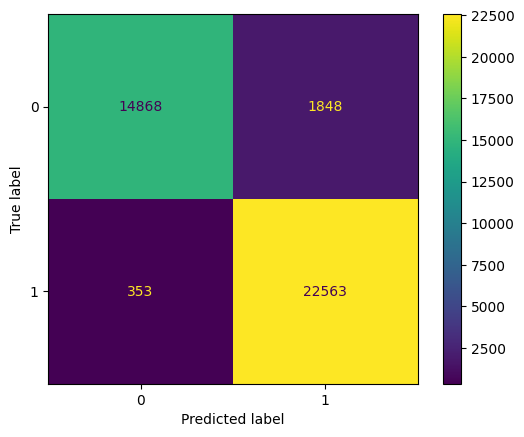

In [125]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_train, y_train_tfidf_pred)

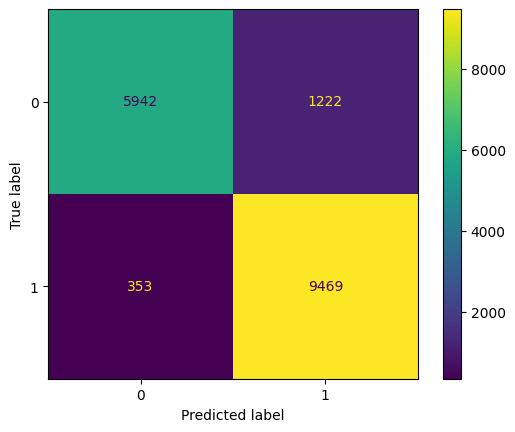

In [126]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_test_tfidf_pred)

In [127]:
if len(bow_clf.classes_) == 2:
    print('Precision:', metrics.precision_score(Y_train, y_train_tfidf_pred, pos_label = 1))
    print('Recall:', metrics.recall_score(Y_train, y_train_tfidf_pred, pos_label = 1))
    print('F1:', metrics.f1_score(Y_train, y_train_tfidf_pred, pos_label = 1))
else:
    print('Precision:', metrics.precision_score(Y_train, y_train_tfidf_pred, average = None))
    print('Recall:', metrics.recall_score(Y_train, y_train_tfidf_pred, average = None))
    print('F1:', metrics.f1_score(Y_train, y_train_tfidf_pred, average = None))

Precision: 0.9242964237433944
Recall: 0.9845959155175423
F1: 0.9534937773364042


In [128]:
if len(tfidf_clf.classes_) == 2:
    print('Precision:', metrics.precision_score(Y_test, y_test_tfidf_pred, pos_label = 1))
    print('Recall:', metrics.recall_score(Y_test, y_test_tfidf_pred, pos_label = 1))
    print('F1:', metrics.f1_score(Y_test, y_test_tfidf_pred, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', metrics.precision_score(Y_test, y_test_tfidf_pred, average = None))
    print('Recall:', metrics.recall_score(Y_test, y_test_tfidf_pred, average = None))
    print('F1:', metrics.f1_score(Y_test, y_test_tfidf_pred, average = None))


Precision: 0.8856982508652137
Recall: 0.9640602728568519
F1: 0.923219421830059


### Error

In [129]:
# Concatenar X_test con Y_test
df_test = pd.concat([X_test, Y_test], axis=1).reset_index(drop=True)

# Convertir predicciones en DataFrame
df_pred = pd.DataFrame({'predicted': y_test_tfidf_pred})

# Unir los DataFrames
error_df = pd.concat([df_test, df_pred], axis=1)

# Renombrar la columna de etiquetas reales si existe
if 'Label' in error_df.columns:
    error_df.rename(columns={'Label': 'actual'}, inplace=True)

# Verificar el resultado
print(error_df.head())

                                               Texto  actual  predicted
0  casado le cobra la factura a la ceoe por su po...       1          1
1  sánchez pide a torra no patrimonializar las in...       1          1
2  rita maestre y el aparato de moncloa volcados ...       0          0
3  la fiscalía rechaza aplazar la sentencia de ju...       1          1
4  el constitucional rechaza las recusaciones de ...       0          0


In [130]:
error_count = (error_df['actual'] != error_df['predicted']).sum()
print(f"Número de errores: {error_count}")

Número de errores: 1575


In [131]:
error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

,Texto,actual,predicted
6632,la marcha de anne hidalgo al grupo mixto del c...,0,1
6118,pilar lima se va al senado la expresidenta de ...,0,1
14141,falciani arropado por pp pide al gobierno que ...,0,1
13100,las bases de eh bildu aprueban concurrir a las...,1,0
8927,ciudadanos toma posición como la organización ...,0,1
8975,pp y cs piden que montón aclare las dudas sobr...,0,1
7541,el gobierno anuncia que está a punto de aproba...,1,0
4821,el gobierno ha dado 630 millones de euros en s...,0,1
906,bescansa aterriza en galicia apuesta segura o ...,0,1
5561,citan como investigado a alberto fernández por...,0,1


### Arboles de decision

In [132]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn import tree

Accuracy: 0.9164017426115625
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      7164
           1       0.93      0.93      0.93      9822

    accuracy                           0.92     16986
   macro avg       0.91      0.91      0.91     16986
weighted avg       0.92      0.92      0.92     16986



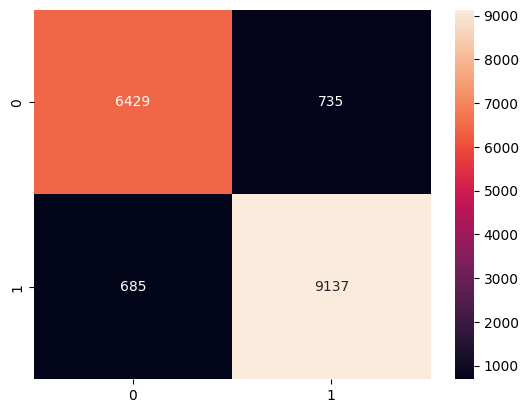

In [144]:
# Crear y entrenar el modelo de árbol de decisión
arbol = DecisionTreeClassifier(random_state=1)
arbol.fit(X_tfidf, Y_train)

# Transformar los datos de prueba
X_tfidf_test = tfidf.transform(X_test)

# Hacer predicciones
Y_pred = arbol.predict(X_tfidf_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(Y_test, Y_pred))

# Matriz de confusión
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d')

# Reporte de clasificación
print(classification_report(Y_test, Y_pred))

In [147]:
# Obtener las palabras del vectorizador TF-IDF
feature_names = tfidf.get_feature_names_out()

# Obtener la importancia de cada palabra en el árbol de decisión
importances = arbol.feature_importances_

# Crear un DataFrame para visualizar los resultados
word_importance = pd.DataFrame({'Palabra': feature_names, 'Importancia': importances})

# Ordenar de mayor a menor importancia
word_importance = word_importance.sort_values(by='Importancia', ascending=False)

# Mostrar las 10 palabras más importantes
print(word_importance.head(10))

        Palabra  Importancia
33931       per     0.112910
19077      equo     0.080640
17321    eajpnv     0.069678
7789        bng     0.048935
31331   narbona     0.047637
8688    canaria     0.027700
40056      rita     0.022421
31247    mónica     0.017508
8691   canarias     0.016584
34846   podemos     0.016390


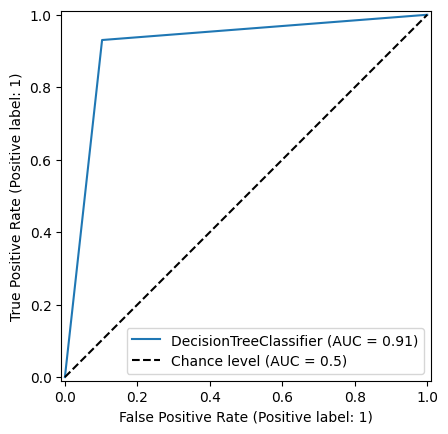

In [146]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_estimator(arbol, X_tfidf_test, Y_test, plot_chance_level=True)


In [136]:
# Fijemos el número de particiones. Utilizaremos K = 10.
from sklearn.model_selection import GridSearchCV, KFold


particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,6,8,10,20]}

# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = DecisionTreeClassifier(random_state=0)

# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(X_tfidf, Y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 20]})

In [137]:
mejor_modelo.best_params_

{'criterion': 'gini', 'max_depth': 20}

In [138]:
# Obtener el mejor modelo.
arbol_final = mejor_modelo.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = arbol_final.predict(X_tfidf)
y_pred_test = arbol_final.predict(X_tfidf_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.88
Exactitud sobre test: 0.88


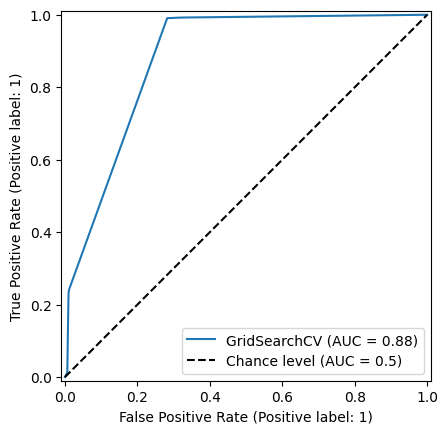

In [139]:
RocCurveDisplay.from_estimator(mejor_modelo, X_tfidf_test, Y_test, plot_chance_level=True)

<Axes: >

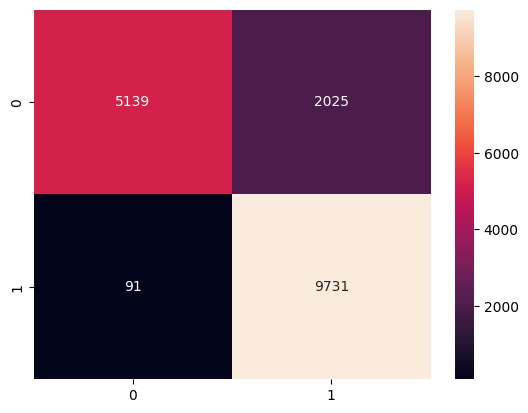

In [140]:
# Matriz de confusión
cm = confusion_matrix(Y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d')

In [141]:
# Reporte de clasificación
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      7164
           1       0.83      0.99      0.90      9822

    accuracy                           0.88     16986
   macro avg       0.91      0.85      0.87     16986
weighted avg       0.89      0.88      0.87     16986

